# Predictive Analysis of Real Estate Market

First and foremost it is useful to understand that the this dataset fits into the long-established [hedonic pricing method](https://stats.oecd.org/glossary/detail.asp?ID=1225) to analyzing housing prices.It is a regression technique in which observed prices of different qualities or models of the same generic good or service are expressed as a function of the characteristics of the goods or services in question. We approach it with a combination of **traditional econometric research and machine learning tools**.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression

ames_housing = pd.read_csv('AmesHousing.txt', delimiter='\t')
pd.options.display.max_columns = 999

### Introduction to the Dataset

The data set describes the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables __(23 nominal, 23 ordinal, 14 discrete, and 20 continuous)__ involved in assessing home values. Information about the different columns in the data is given [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

In [2]:
ames_housing

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120,0,0,0,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,GasA,TA,Y,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1983.0,Unf,2.0,484.0,TA,TA,Y,164,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,

The factors that effect housing prices may include:
- Property size
- Location Desirability
- Nearby Amenities
- Number of Rooms
- Construction Materials
- Age and condition of the structure  

Armed with this prior knowledge, let's get analyzing the data using Python. 

### Feature Engineering & Data Cleaning

In [3]:
ah_data = ames_housing.copy() 
nan_threshold = int(0.05*len(ah_data))
ah_data.loc[:, (ah_data.isnull().sum() > nan_threshold)]

,Lot Frontage,Alley,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Qual,Garage Cond,Pool QC,Fence,Misc Feature
0,141.0,NaN,Gd,Attchd,1960.0,Fin,TA,TA,NaN,NaN,NaN
1,80.0,NaN,NaN,Attchd,1961.0,Unf,TA,TA,NaN,MnPrv,NaN
2,81.0,NaN,NaN,Attchd,1958.0,Unf,TA,TA,NaN,NaN,Gar2
3,93.0,NaN,TA,Attchd,1968.0,Fin,TA,TA,NaN,NaN,NaN
4,74.0,NaN,TA,Attchd,1997.0,Fin,TA,TA,NaN,MnPrv,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2925,37.0,NaN,NaN,Detchd,1984.0,Unf,TA,TA,NaN,GdPrv,NaN
2926,NaN,NaN,NaN,Attchd,1983.0,Unf,TA,TA,NaN,MnPrv,NaN
2927,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MnPrv,Shed
2928,77.0,NaN,TA,Attchd,1975.0,RFn,TA,TA,NaN,NaN,NaN


The columns `Exter Qual`, `Exter Cond`, `Bsmt Qual`, `Bsmt Cond`, `Heating QC`, `Kitchen Qual`, `Fireplace Qu`, `Garage Qual`, `Garage Cond` and `Pool QC` give a measure of the quality or condition with the help of the following notation:-  
> `Ex`	Excellent  
> `Gd`	Good  
> `TA`	Typical/Average  
> `Fa`	Fair  
> `Po`	Poor  
> `NA`	No Garage  

Let's create a mapping dictionary that maps each string value to a numerical value. A higher numerical value corresponds to better quality or condition.

In [4]:
mapping_dict = {'Ex':5,
                'Gd':4,
                'TA':3,
                'Fa':2,
                'Po':1,
                 np.nan:0}

# 'NA' values are instead stored as NaN values owing to a lot of null values in some of the columns.

cols_to_map = ['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu',
               'Garage Qual', 'Garage Cond', 'Pool QC']

for col in cols_to_map:
    ah_data[col] = ah_data[col].map(mapping_dict)

Let's have a look at the number of missing values in columns again. We'll drop the columns with more than 5% of missing values.

In [5]:
ah_data.loc[:, (ah_data.isnull().sum() > nan_threshold)]

,Lot Frontage,Alley,Garage Type,Garage Yr Blt,Garage Finish,Fence,Misc Feature
0,141.0,NaN,Attchd,1960.0,Fin,NaN,NaN
1,80.0,NaN,Attchd,1961.0,Unf,MnPrv,NaN
2,81.0,NaN,Attchd,1958.0,Unf,NaN,Gar2
3,93.0,NaN,Attchd,1968.0,Fin,NaN,NaN
4,74.0,NaN,Attchd,1997.0,Fin,MnPrv,NaN
...,...,...,...,...,...,...,...
2925,37.0,NaN,Detchd,1984.0,Unf,GdPrv,NaN
2926,NaN,NaN,Attchd,1983.0,Unf,MnPrv,NaN
2927,62.0,NaN,NaN,NaN,NaN,MnPrv,Shed
2928,77.0,NaN,Attchd,1975.0,RFn,NaN,NaN


In [6]:
missing_val = ah_data.loc[:, (ah_data.isnull().sum() > nan_threshold)].columns
ah_data.drop(columns=missing_val, inplace=True)

Next, for numerical columns which contain less than 5% missing values, let's fill in the missing values using the most popular value for that column. The remaining columns can be dropped.

In [7]:
num_cols = (ah_data.loc[:, (ah_data.isnull().sum() > 0)]
                       .select_dtypes(exclude='object')
                       .columns
           )

for col in num_cols:
    pop_val = ah_data[col].value_counts().index[0]
    ah_data[col].fillna(pop_val, inplace=True)
    
ah_data.dropna(axis=1, inplace=True)

Let's look into the `Sale Condition` column, which records the type of sales for each transaction. Most observations were in the “Normal” sale category, but there were 113 observations recorded as “Abnormal” or “Family” (intra-family sale). I zoomed in on these, and noted that both their mean and median sale prices (and price per square foot) were below those of the overall sample. This prompted me to exclude these 113 unusual sale transactions from the analysis. If these transactions were not primarily commercial in nature, then their inclusion in the dataset would introduce bias into a model trying to estimate the economic relationship between housing characteristics and house prices.

In [8]:
ah_data['Sale Condition'].value_counts()

Normal     2413
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: Sale Condition, dtype: int64

Most observations were in the “Normal” sale category, but there were **236** observations recorded as `Abnorml` or `Family` (intra-family sale).

In [9]:
print(ah_data.loc[(ah_data['Sale Condition'] == 'Abnorml') | (ah_data['Sale Condition'] == 'Family')]['SalePrice'].mean())
print(ah_data['SalePrice'].mean())

143727.8093220339
180796.0600682594


Note that both their mean sale prices are below those of the overall sample. Let's exclude these 236 unusual sale transactions from the analysis. If these transactions were not primarily commercial in nature, then their inclusion in the dataset would introduce bias into a model trying to estimate the economic relationship between housing characteristics and house prices.

In [10]:
ah_data = ah_data.loc[~((ah_data['Sale Condition'] == 'Abnorml') | (ah_data['Sale Condition'] == 'Family'))]

Let's have a look at the column `SalePrice`, our target variable's distribution.

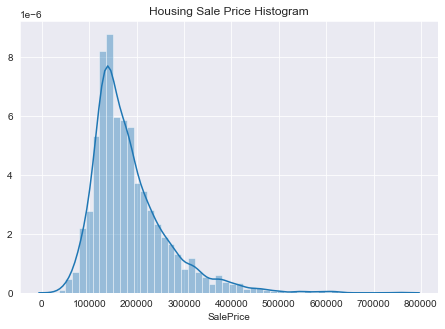

In [11]:
plt.figure(figsize=(7.5, 5))
sns.distplot(ah_data['SalePrice'])
plt.title('Housing Sale Price Histogram')
plt.show()

Looking at the histogram of the dependent variable, “SalePrice”. It is immediately obvious that it has extreme high values (a long right-tail) and is not distributed normally. 

Undertaking a natural log-transformation of “SalePrice”

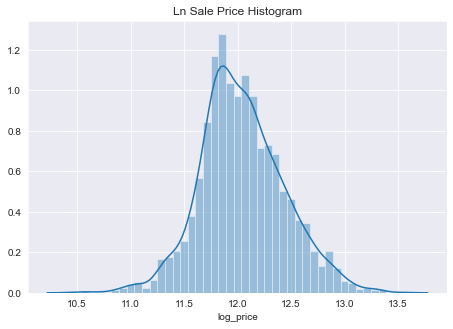

In [12]:
ah_data['log_price'] = np.log(ah_data['SalePrice'])
plt.figure(figsize=(7.5, 5))
sns.distplot(ah_data['log_price'])
plt.title('Ln Sale Price Histogram')
plt.show()

The histogram of log sale prices definitely appeared more symmetrical, with less extreme values. It is very common to take the log transformation in economic research. The resulting model is a log-linear model, meaning a log dependent variable with linear explanatory variables.

Let's explore the `Neighborhood` column next. House prices depend a lot on the neighborhood they're located in.

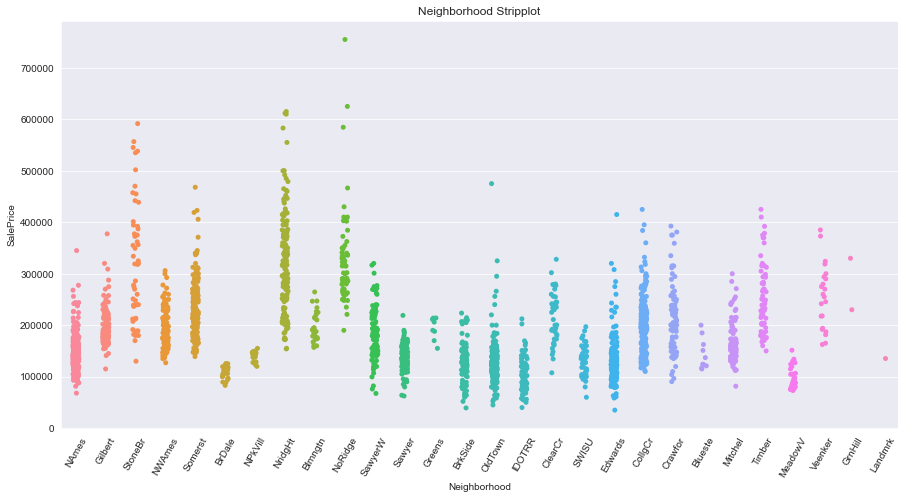

In [13]:
plt.figure(figsize=(15, 7.5))
sns.stripplot(x='Neighborhood', y='SalePrice', data=ah_data)
plt.xticks(rotation=60)
plt.title('Neighborhood Stripplot')
plt.show()

In [14]:
ames_housing['Neighborhood'].value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

Clearly the column is of `object` dtype and cannot be used in our regression model in its raw form. We chose instead to construct an ordinal neighborhood `Location` desirability variable out of various building quality and condition variables in the dataset, notably `Overall Qual`, `Overall Cond`, `Exter Qual`, `Exter Cond` and `Functional`. The motivation behind my methodology was the assumption that the more desirable a neighborhood, the better the quality of its housing structures and their condition.

In [15]:
# Convert the column `Functional` to numeric data type
mapping_func = {'Typ':7,
                'Min1':6,
                'Min2':5,
                'Mod':4,
                'Maj1':3,
                'Maj2':2,
                'Sev':1,
                'Sal':0}

ah_data['Functional'] = ah_data['Functional'].map(mapping_func)

Let's use an unsupervised learning algorithm to cluster the `Neighborhood` into 4 groups based off the features `Overall Qual`, `Overall Cond`, `Exter Qual`, `Exter Cond` and `Functional`. We'll group the data set by the `Neighborhood` column and use the mean value of the features as a measure for each unique value in `Neighborhood`.

In [16]:
ngb_rating = ah_data.groupby('Neighborhood')[['Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Functional']].mean()
ngb_rating

,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Functional
Neighborhood,,,,,
Blmngtn,7.142857,5.000000,4.000000,3.000000,7.000000
Blueste,6.600000,5.800000,3.200000,3.300000,7.000000
BrDale,5.730769,5.500000,3.000000,3.000000,6.884615
BrkSide,5.153061,6.214286,3.020408,3.122449,6.724490
ClearCr,6.025641,5.692308,3.282051,3.102564,6.564103
CollgCr,6.686047,5.236434,3.736434,3.069767,6.984496
Crawfor,6.260417,6.302083,3.322917,3.177083,6.750000
Edwards,5.098266,5.566474,3.121387,3.080925,6.624277
Gilbert,6.518987,5.094937,3.556962,3.012658,6.968354


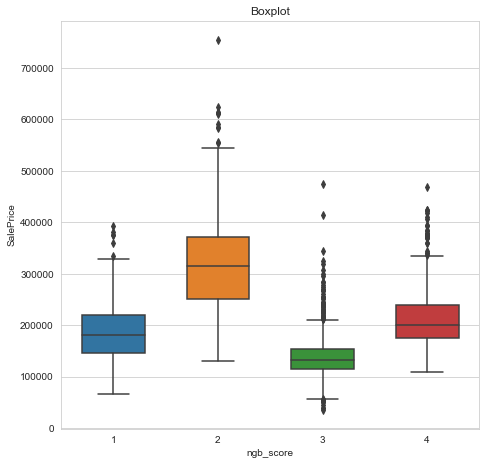

In [20]:
kmeans_model = KMeans(n_clusters=4, random_state=1)
kmeans_model.fit(ngb_rating)
ngb_rating['ngb_score'] = kmeans_model.labels_ + 1 # Prefer values from 1 to 4 while labels range from 0 to 3

ah_data['ngb_score'] = ah_data['Neighborhood'].map(ngb_rating['ngb_score'])

sns.set_style('whitegrid')
f, axs = plt.subplots(figsize=(7.5, 7.5))
axs = sns.boxplot(x="ngb_score", y="SalePrice", data=ah_data, width=0.6)
axs.set_title('Boxplot')
plt.show()

The unsupervised learning algorithm **K-means** clustered the `Neighborhood` column into 4 groups. Although the labels allocated to each group are random, each group does correspond to a different price range as is inferred from the above boxplots. Let's remap the `ngb_score` column such that higher values are allotted to more expensive neighborhoods.

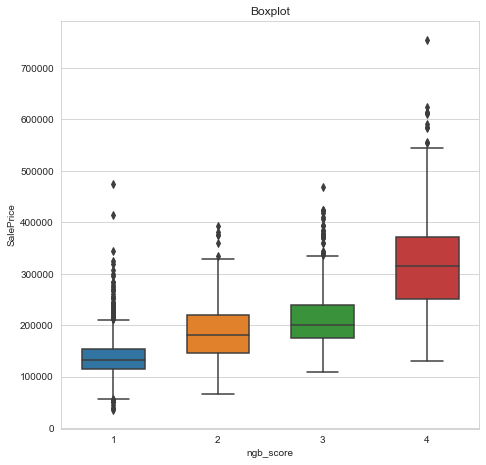

In [21]:
map_score = {2:4, 4:3, 1:2, 3:1}
ah_data['ngb_score'] = ah_data['ngb_score'].map(map_score)

f, axs = plt.subplots(figsize=(7.5, 7.5))
axs = sns.boxplot(x="ngb_score", y="SalePrice", data=ah_data, width=0.6)
axs.set_title('Boxplot')
plt.show()

As expected there is a postive correlation between `SalePrice` and each `Location` group.

A new features can we create, that better capture the information about the age of the property is `Years Since Remod`.

In [22]:
ah_data['Years Since Remod'] = ah_data['Yr Sold'] - ah_data['Year Remod/Add']

Finally let's drop columns -
- That aren't useful for machine learning
- Leak data about the final sale

In [23]:
## Drop columns that aren't useful for ML
ah_data = ah_data.drop(["PID", "Order"], axis=1)

## Drop columns that leak information about the final sale
ah_data = ah_data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

## Feature Selection

Generating a correlation heatmap matrix of the numerical features in the training data set.

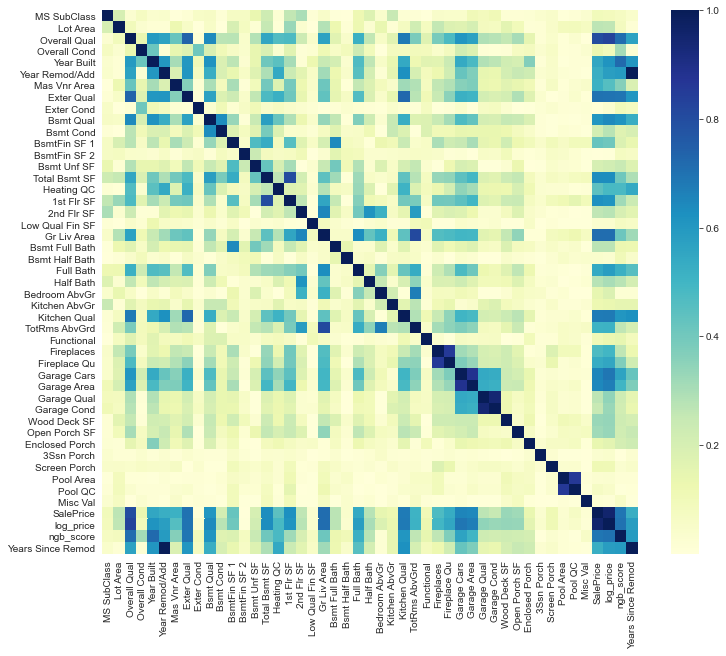

In [26]:
corr_df = np.absolute(ah_data.select_dtypes(exclude='object').corr())

fg, axes = plt.subplots(figsize=(12, 10))
axes = sns.heatmap(corr_df, cmap='YlGnBu')
plt.show()

In [27]:
high_corr = ah_data.select_dtypes(exclude='object').columns[corr_df['SalePrice'] > 0.6]
high_corr

Index(['Overall Qual', 'Exter Qual', 'Bsmt Qual', 'Total Bsmt SF',
       '1st Flr SF', 'Gr Liv Area', 'Kitchen Qual', 'Garage Cars',
       'Garage Area', 'SalePrice', 'log_price', 'ngb_score'],
      dtype='object')

Dropping discrete variables and non-features.

In [28]:
cont_fts = high_corr[[0, 1, 2, 3, 4, 5, 6, 8]]

`SelectKBest` removes all but the `k` highest scoring features. We use the test `f_regression`, a univariate linear regression test. Tests the individual effect of each of many regressors. This is done in 2 steps:
1. The pearson correlation coefficient (PCC) between each regressor and the target is computed.
2. It is converted to an F score then to a p-value.

In [30]:
six_best = SelectKBest(f_regression, k=6).fit(ah_data[cont_fts], ah_data['SalePrice']).get_support()
cont_fts[six_best]

Index(['Overall Qual', 'Exter Qual', 'Total Bsmt SF', 'Gr Liv Area',
       'Kitchen Qual', 'Garage Area'],
      dtype='object')

In addition to these features we will use the discrete `ngb_score` and `Years Since Remod` features to train our model. 

In [31]:
num_best = list(cont_fts[six_best])
num_best.append('ngb_score')
num_best.append('Years Since Remod')

Let's create dummies for categorical columns. 

In [32]:
# One dummy for the property being near an artery road or railway line. 
unfav_loc = ah_data['Condition 1'].apply(lambda x: int(x in ['Artery', 'RRNn', 'RRAn', 'RRNe', 'RRAe']))
unfav_loc.rename('Unfav Loc', inplace=True)

# One dummy for the property being near positive amenities such as a park.
fav_loc = ah_data['Condition 1'].apply(lambda x: int(x in ['PosN', 'PosA']))
fav_loc.rename('Fav Loc', inplace=True)

# One dummy for a central air condition system.
air_cond = (ah_data['Central Air'] == 'Y').astype('int64')

# One dummy for houses higher than one floor.
multi_storey = ah_data['House Style'].apply(lambda x: int(x in ['2Story', '2.5Fin', '2.5Unf']))

Combining all the features and target variables.

In [33]:
final_data = ah_data[num_best]
final_data = pd.concat([final_data, unfav_loc, fav_loc, air_cond, multi_storey, ah_data[['SalePrice', 'log_price']]], axis=1)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2694 entries, 0 to 2929
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Overall Qual       2694 non-null   int64  
 1   Exter Qual         2694 non-null   int64  
 2   Total Bsmt SF      2694 non-null   float64
 3   Gr Liv Area        2694 non-null   int64  
 4   Kitchen Qual       2694 non-null   int64  
 5   Garage Area        2694 non-null   float64
 6   ngb_score          2694 non-null   int64  
 7   Years Since Remod  2694 non-null   int64  
 8   Unfav Loc          2694 non-null   int64  
 9   Fav Loc            2694 non-null   int64  
 10  Central Air        2694 non-null   int64  
 11  House Style        2694 non-null   int64  
 12  SalePrice          2694 non-null   int64  
 13  log_price          2694 non-null   float64
dtypes: float64(3), int64(11)
memory usage: 395.7 KB


## Training & Testing

We will use K-Fold cross validation with a k-value of 10 to test our model. Our target variable will be the normally distributed `log_price` column.

In [34]:
def train_and_test2(df):
    # Cross Validation Strategy
    kf = KFold(10, shuffle=True, random_state=1)
    # Features
    features = final_data.drop(['SalePrice', 'log_price'], axis=1)
    # Target
    target = final_data['log_price']
    # Regression Model
    model = LinearRegression()
    # Performance Evaluation
    mses = cross_val_score(model, features, target, scoring='neg_mean_squared_error', cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    
    return avg_rmse

train_and_test2(final_data)

0.14733293794042696

In [35]:
np.exp(0.14733293794042696)

1.1587396872201376

Corresponds to an error of about **15 %** while predicting the price of real estate.